# Project Assignment B
Link to git repository: https://github.com/ongiboy/computational_social_science

Group members:
* Christian Ong Hansen (s204109)
* Kavus Latifi Yaghin (s214601)
* Daniel Damkjær Ries (s214641)

Group member's contribution:
* Every task was made in collaboration by all members.

## 1. Motivation

* What is your dataset

Our dataset is ready-made data that originates from The Movie Database (TMDB) via its API. The data is collected from the "Popular People" tab on the webpage, and includes the top actors from the first 250 pages, with each page containing data for 20 actors. The popularity score attributed to actors by TMDB is a metric not publicly disclosed, but it's generally understood to consider factors like page views, favorites, watchlists, and recent activity.

The data is structured into two main dataframes: one for actors and their attributes (name, ID, gender, age, birthplace, and filmography), and another for movies featuring these actors (rating, popularity, genres, release date, and abstract for text analysis). This setup forms the basis for our actor collaboration network and analysis, which is essential for answering our research question: Based on collaborations among the most popular actors, do distinct communities form, and if so, what characterizes the most succesful communities?

* Why did you choose this/these particular dataset(s)?

The reason for us choosing The Movie Database (TMDB) as the data source for our project is because of our interest in exploring and analyzing the film industry by an actor collaboration network. TMDB has a broad coverage of the film industry and it has built a reputation for being a well-known data source within the field. TMDB is widely recognized for its movie-related data, containing details on actors, movies, genres, ratings, popularity etc.. The rate limit for the API (50 calls per second) was also an attractive factor. 

It was therefore believed that through TMDB's API, it would be possible to access up-to-date and reliable data on popular actors and their participation in movies, enabling us to explore actor interactions and movie trends effectively. In this way the TMDB datasource can be used to contribute valuable insights to the broader understanding of the film industry landscape.

* What was your goal for the end user’s experience?

The goal of this project for the end user's experience was to provide insights into the characteristics and dynamics of successful actor communities. By analyzing data from popular actors and their collaborations in a network, we sought to offer a user-friendly interface for exploring trends, identifying influential factors, and gaining a deeper understanding of what drives success in the film industry in an actor perspective.


## 2. Basic stats
* Write about your choices in data cleaning and preprocessing

Using the TMDB API it was possible to retrieve information about popular actors just by using an API-key and selecting the desired number of pages with 20 actors in each page. 250 pages were chosen as a reasonable amount, which in theory would lead to a raw dataset consisting of 6000 actors, but in practice ended up being 5564 actors. This would be the first dataframe "df_actors". Since it wasn't possible to use filters directly in the API-call, data processing was performed after the data was collected. The information about these actors that was collected were the attributes: name, id, gender, birthday, place_of_birth and popularity. In this project the focus is on recent actors, and therefore actors who passed away before 2010 are not part of the dataframe.

Initially, all rows with missing values in the attributes of interest were removed and duplicate rows were removed. Since all the collected information about the actors is crucial for the analysis, this seemed a reasonable part of the cleaning. 

Using the retrieved actor IDs, it was now possible to get a complete list of the movies that each actor has played a role in as well as the movie ID - again using the TMDB API. This also laid the foundation for the second dataframe "df_movies" with the purpose of being our own little movie-database containing information about all the movies that the actors in the "df_actors" dataframe have been part of. Before any processing, the dataframe included 67587 movies.

With yet another API call using the found movie IDs, the desired information could be obtained, which consisted of the attributes: rating, popularity, genres, release date and movie abstract. After retrieval of movie information in the movies dataframe, all rows with missing values in any of the attributes were removed. Furthermore, it was decided for this project to only focus on "recent" movies, which in this case is defined as movies from 2010 and until the date of collection (08-05-2024). This way, the resulting data was used to generate a network of today's collaboration among popular actors, rather than a network with old data from many decades ago. After this processing the movie dataset consisted of 26494 movies.

The outfiltered movies in the movies dataframe, were also removed from the actor dataframe, so the two dataframes would be consistent. After this filtering, actors with an empty movie list were removed, which cut down the number of actors to exactly 5100 in the actors dataframe.

Through further investigation of the actors dataframe, it was found that the "birthplace" column needed processing. Firstly, the birthplace was reduced to only include the country of birth for the actors, but it was also found that the same countries were spelled differently. The country could be in different languages, symbols, etc., which could introduce misleading findings. The birthplace column was normalized so there would be no double instances of a country of birth. 

It was in our interest to select a main genre for each actor. Each movie has a list of given genres, and by finding the genre that appeared the most in the movies that the actor has been part of, a main genre for an actor was found. One issue that had to be adressed was regarding the "Drama" genre, where the problem was that a significant amoutn of movies were partially catogarized as "Drama". The internet defines the drama genre as movies that invokes emotion and features character development, which could characterise almost all movies. To overcome this challenge without removing the drama genre entirely, the drama category is removed from the genre list if there is more than 1 other category. In this way it is avoided that all actors would be "Drama" actors. 

Finally, from the TMDB API there is no direct actor rating measure, which gave us the idea to create our own measure. This measure was created as the mean of the ratings from all the movies the actor has acted in, of the more recent movies (2010-2024). 

Now that the data had been cleaned and preprocessed, it was time to create the actual network. The edges of the network were weighted by the number of times two actors had collaborated. This led to a very dense network, filled with cliques, since every movie creates a fully-connected clique containing the starring actors. Therefore a threshold of 2 movies was set, so that there would only be an edge if the actors had collaborated at least twice. This both drastically reduces the amount of cliques and makes the network less dense. The final network consisted of the 5100 actors/nodes with 23736 edges. In the network there are 1680 isolated nodes, which refers to popular actors who have been part of movies since 2010, but not with anyone in this network. The largest component of the network consists of 3341 nodes and the network has a density of 0.0018. 

* Write a short section that discusses the dataset stats

This project is based on two datasets, one for actor information and the other for movie information.
These datasets have the following stats:

Actor dataframe: 5100 rows of size 4.134 KB

Movie Dataframe: 30086 rows of size 10.905 KB

From these a network was made of actor collaborations, with the following stats:
5100 nodes and 23736 edges, of size 2.388 KB

## Data retrieval and cleaning/preprocessing

### Importing libraries

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import concurrent.futures
import requests
import itertools
import networkx as nx
from collections import defaultdict
from functools import partial
from tqdm import tqdm
from requests_futures.sessions import FuturesSession
import matplotlib.pyplot as plt
import ast
import numpy as np
from statistics import mode
import json
from threading import Lock
import matplotlib.cm as cm
import pycountry
import re
import netwulf as nw
import matplotlib.patches as mpatches
import community.community_louvain as community_louvain
from IPython.display import Image, display, HTML
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.stem import PorterStemmer
from collections import Counter
import math
from wordcloud import WordCloud
from nltk import bigrams
import collections
from scipy import stats
import seaborn as sns
from scipy.stats import pearsonr

headers = {"accept": "application/json"}
api_key = "f5813332cb558d374cbcb057ea2fc48b"

In [ ]:
df_movies_filtered

### Functions used to make API calls

In [ ]:
counter = 0
lock = Lock()

def movie_title_and_IDs_from_actor_ID(actor_id, session):
    global counter
    url = f"https://api.themoviedb.org/3/person/{actor_id}/movie_credits?api_key={api_key}"
    response = session.get(url)
    data = response.json()

    with lock:
        counter += 1
        if counter % 1000 == 0:
            print(f"Processed {counter} actors")
    # Return the whole movie dictionary, not just the title
    return [movie['title'] for movie in data['cast']], [movie['id'] for movie in data['cast']]

def actor_info_from_page(page, session):
    url = f"https://api.themoviedb.org/3/person/popular?api_key={api_key}&page={page}"
    response = session.get(url)
    data = response.json()
    people = []
    for person in data['results']:
        person_url = f"https://api.themoviedb.org/3/person/{person['id']}?api_key={api_key}"
        person_response = session.get(person_url)
        person_data = person_response.json()
        if person_data['deathday'] is not None:
            if person_data['deathday'] < '2010-01-01':
                continue
        people.append((person['name'], person['id'], person_data['gender'], person_data['birthday'], person_data['place_of_birth'], person_data['popularity']))
    return people

In [ ]:
counter = 0
lock = Lock()

def fetch(session, url):
    global counter
    future = session.get(url, headers=headers)
    with lock:
        counter += 1
        if counter % 10000 == 0:
            print(f"Processed {counter} movies")
    
    return future

def movie_info_from_movie_ID(urls):
    with FuturesSession() as session:
        futures = [fetch(session, url) for url in urls]
        responses = [future.result().json() for future in tqdm(futures, total=len(futures))]
    return responses

### Retrieve actor information (name, id, gender, birthday, birthplace, popularity)

In [ ]:
with requests.Session() as session:
    session.headers.update(headers)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        pages = list(range(1, 301))
        fetch_page_with_session = partial(actor_info_from_page, session=session)
        people = list(executor.map(fetch_page_with_session, pages))

actor_names, actor_ids, actor_genders, actor_birthdays, actor_birthplaces, actor_popularities = zip(*itertools.chain(*people))

### Creating the Actor Dataframe and initial preprocessing

In [ ]:
# Create a DataFrame with 'actors' column
df_actors = pd.DataFrame(actor_names, columns=['actor'])

# Add 'ids', 'genders', and 'birthplaces' columns to the DataFrame
df_actors['actor_id'] = actor_ids
df_actors['gender'] = actor_genders
df_actors['age'] = actor_birthdays # This is not the age, but the birthday
df_actors['birthplace'] = actor_birthplaces
df_actors['popularity'] = actor_popularities

# Change birthplaces so that it only contains the country (text after the last comma)
df_actors['birthplace'] = df_actors['birthplace'].str.split(',').str[-1]

# Change birthday to age
df_actors['age'] = pd.to_datetime(df_actors['age'], errors='coerce')
df_actors['age'] = (pd.to_datetime('today') - df_actors['age']).dt.days // 365

# Drop rows with missing values
df_actors.dropna(inplace=True)

# Drop duplicates
df_actors.drop_duplicates(subset='actor_id', inplace=True)
#reset index
df_actors.reset_index(drop=True, inplace=True)

### Retrieve movie titles and IDs

In [ ]:
# Fetch movies for each actor and add them to 'movies' and 'movie_IDs' columns
with requests.Session() as session:
    session.headers.update(headers)
    movie_titles_and_ids_from_actor_ID_with_session = partial(movie_title_and_IDs_from_actor_ID, session=session)
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        movies_and_ids = list(executor.map(movie_titles_and_ids_from_actor_ID_with_session, df_actors['actor_id']))

# Add 'movies' column to df_actors
df_actors['movies'] = [x[0] for x in movies_and_ids]
df_actors['movie_IDs'] = [x[1] for x in movies_and_ids]

# Flatten movies_and_ids into two separate lists
movies = [item for sublist in [x[0] for x in movies_and_ids] for item in sublist]
ids = [item for sublist in [x[1] for x in movies_and_ids] for item in sublist]

# Convert the lists into a list of dictionaries
movies_and_ids_dict = [{'movie': movie, 'movie_ID': id} for movie, id in zip(movies, ids)]

# Convert the list of dictionaries into a DataFrame
df_movies = pd.DataFrame(movies_and_ids_dict)
df_movies = df_movies.drop_duplicates(subset='movie_ID')
df_movies.reset_index(drop=True, inplace=True)

### Collect movie information trough API (rating, popularity, genre, release date, abstract)

In [ ]:
# Prepare the URLs
urls = [f"https://api.themoviedb.org/3/movie/{id}?api_key={api_key}" for id in df_movies["movie_ID"]]
print('urls are prepared')

# Fetch all responses
responses = movie_info_from_movie_ID(urls)
print('all responses are fetched')

# Process the responses
for i, response in enumerate(responses):
    # if i % 100 == 0:
    #     print(f"Processing response {i+1}/{len(responses)}")
    if isinstance(response, Exception):
        print(f"Error: {response}")
        continue  # Skip this response
    # Process the response here

# Initialize empty lists to store the data
ratings = []
popularities = []
genres = []
release_dates = []
abstracts = []

# Process the responses one by one
for data in tqdm(responses):
    ratings.append(data.get('vote_average'))
    popularities.append(data.get('popularity'))
    genres.append([genre['name'] for genre in data.get('genres', [])])
    release_dates.append(data.get('release_date'))
    abstracts.append(data.get('overview'))

# Assign the lists to the DataFrame columns
df_movies['rating'] = ratings
df_movies['popularity'] = popularities
df_movies['genres'] = genres
df_movies['release_date'] = release_dates
df_movies['abstract'] = abstracts

### Initial preprocessing of Movies Dataframe

In [ ]:
# Drop duplicates
df_movies.drop_duplicates(subset='movie', inplace=True)

# Drop rows with missing values
df_movies.dropna(inplace=True)

# Remove rows with empty lists in 'genres' column
df_movies = df_movies[df_movies['genres'].apply(lambda x: len(x) > 0)]

# Remove rows with empty release dates
df_movies = df_movies[df_movies['release_date'].apply(lambda x: len(x) > 0)]

# Drop row if abstract is missing
df_movies = df_movies[df_movies['abstract'].apply(lambda x: len(x) > 0)]

# Drop row if rating is missing
df_movies = df_movies[df_movies['rating'].apply(lambda x: x > 0)]

# Drop row if popularity is missing
df_movies = df_movies[df_movies['popularity'].apply(lambda x: x > 0)]

# Reset index
df_movies.reset_index(drop=True, inplace=True)

### Remove old and future movies

In [ ]:
# Combine the two dataframes so that each actor is associated with the movies they have acted in
df_actors_filtered = df_actors.copy()
df_movies_filtered = df_movies.copy()
df_movies_filtered.rename(columns={'movie_ID': 'movie_IDs'}, inplace=True)
df_movies_filtered.rename(columns={'popularity': 'movie_popularity'}, inplace=True)
df_actors_filtered.drop(columns=['movies'], inplace=True)

df_actors_filtered = df_actors_filtered.explode('movie_IDs').reset_index(drop=True)

df_actors_movies = df_actors_filtered.merge(df_movies_filtered, on='movie_IDs', how='inner')

# Remove all rows where the release date is before 2010 or after 2024 (to avoid movies that have not been released yet)
df_actors_movies = df_actors_movies[(df_actors_movies['release_date'] >= '2010-01-01') & (df_actors_movies['release_date'] <= '2024-05-08')]

# Collapse the the actors in the actor column so there is only one row per actor and the movies and movie_IDs are stored in lists
df_actors_filtered = df_actors_movies.groupby('actor').agg({'actor_id': 'first',
                                                             'gender': 'first',
                                                             'birthplace': 'first',
                                                             'age': 'first',
                                                             'popularity': 'first',
                                                             'movie': list, 
                                                             'movie_IDs': list}).reset_index()

df_movies_filtered = df_actors_movies.drop_duplicates(subset=['movie']).groupby('movie').agg({'movie_IDs': 'first',
                                                                                               'rating': 'first',
                                                                                               'popularity': 'first',
                                                                                               'genres': 'first',
                                                                                               'release_date': 'first',
                                                                                               'abstract': 'first'}).reset_index()

df_actors_filtered.rename(columns={'movie': 'movies'}, inplace=True)
df_movies_filtered.rename(columns={'movie_IDs': 'movie_ID'}, inplace=True)

# Remove actors with empty lists of movies
df_actors_filtered = df_actors_filtered[df_actors_filtered['movies'].apply(lambda x: len(x) > 0)]

### Cleaning the birthplace column, to avoid having the same country spelled differently and removing symbols

In [ ]:
# Clean birthplace column in actor dataframe
len_bef_clean = len(df_actors_filtered['birthplace'].unique())

country_names = [country.name for country in pycountry.countries]

def normalize_country_name(name):
    # strip name
    name = name.strip()
    # replace '.' with ''
    name = name.replace('.', '').replace(']', '')

    if "UK" in name or "İngiltere" in name:
        return "United Kingdom"
    try:
        # Try to get the country object
        country = pycountry.countries.get(name=name)
        if country is not None:
            # If the country object is found, return the official name
            return country.name
        else:
            # If the country object is not found, try to find it by its common name
            country = pycountry.countries.search_fuzzy(name)
            return country[0].name
    except LookupError:
        # Standardizing names
        for country_name in country_names:
            if country_name in name:
                name = country_name

        # Fixing abbreviations and wird instances
        if "Russia" in name:
            return "Russian Federation"
        elif "Türkiye" in name or "Turkey" in name:
            return "Türkiye"
        elif "USA" in name or " US" in name or "United States" in name:
            return "United States"
        elif "Korea" in name:
            return "Korea, Republic of"
        elif "Czech" in name:
            return "Czechia"
        # Hardcoded, could use package to translate, maybe not necessary, few occurences
        elif "TX" in name:
            return "United States"
        elif "Frankrike" in name:
            return "France"
        elif "Afrique du Sud" in name:
            return "South Africa"
        elif "Irlanda" in name:
            return "Ireland"
        elif "中国" in name or "中华民国" in name or "重庆" in name or "南京" in name:
            return "China"
        
        
        # Updating from old names
        if "now" in name:
            match = re.search(r'\[now (.*?)', name)
            if match:
                return match.group(1)

        # If the country is not found, return the original name
        return name

# Normalize the country names in the DataFrame
df_actors_filtered['birthplace'] = df_actors_filtered['birthplace'].apply(normalize_country_name)
df_actors_filtered = df_actors_filtered.dropna(subset=['birthplace'])

len_aft_clean = len(df_actors_filtered['birthplace'].unique())
# print("length before cleaning", len_bef_clean)
# print("length after cleaning", len_aft_clean)

### Finding the main genre for the popular actors

In [ ]:
# Function to find the genre counts and main genre of an actor
def find_genres_and_main_genre(movies_list, remove_drama=False): # nearly half of all movies have drama as genre, so not descriptive
    # Get the genres of the movies
    genres = [genre for movie in movies_list for genre in movie_genres.get(movie, [])]
    # Count the frequency of each genre
    genre_counts = pd.Series(genres).value_counts()
    # Remove the 'Drama' genre if specified
    if remove_drama and len(genre_counts) > 2:
        genre_counts.drop('Drama', errors='ignore', inplace=True)
        #genre_counts.drop('Thriller', errors='ignore', inplace=True)
    
    # Return the genre counts as a dictionary and the main genre
    return genre_counts.to_dict(), genre_counts.idxmax() if not genre_counts.empty else None

movie_genres = df_movies_filtered.set_index('movie')['genres'].to_dict()
# Apply the function to the 'movies' column of the actors DataFrame and create two new columns
df_actors_filtered['genres'], df_actors_filtered['main_genre'] = zip(*df_actors_filtered['movies'].apply(find_genres_and_main_genre, remove_drama=True))


### Actor rating

In [ ]:
# Function to find the average rating and popularity of an actor
def find_actor_rating(movies_list):
    # Get the ratings for each movie
    ratings = [movie_ratings[movie] for movie in movies_list if movie in movie_ratings]
    avg_rating = np.mean(ratings)

    return ratings, avg_rating

movie_ratings = df_movies_filtered.set_index('movie')['rating'].to_dict()

# Apply the function to the 'movies' column of the actors DataFrame and create two new columns
df_actors_filtered['ratings'], df_actors_filtered['avg_rating'] = \
        zip(*df_actors_filtered['movies'].apply(find_actor_rating))

### Saving the final dataframes

In [ ]:
# save the dataframes to csv files
df_actors_filtered.to_csv('data/actors.csv', index=False)
df_movies_filtered.to_csv('data/movies.csv', index=False)

### Taking a look into the data of interest, distributions and correlations

Actor numeric data

In [ ]:
# Function for correlation
def corr_func(x, y, **kwargs):
    r = pearsonr(x, y)[0]
    ax = plt.gca()
    size = np.sqrt(np.abs(r)) * 75  # Non-linear scaling for size
    color = 'cornflowerblue' if r > 0 else 'firebrick'  # Blue for positive, red for negative
    ax.annotate(f"{r:.2f}", xy=(.5, .5), xycoords=ax.transAxes, 
                size=max(size, 10),  # Minimum size to ensure readability
                ha='center', va='center', color=color)

# Function to label diagonal plots
def label_diag(x, **kwargs):
    ax = plt.gca()
    ax.set_title(x.name)  # Set the title to the variable name

df_actors_numeric = df_actors_filtered[['age', 'popularity', 'avg_rating']]

# Create an empty pairgrid with a custom color palette
sns.set(style="white", palette="husl")
grid = sns.PairGrid(df_actors_numeric)

# Map the plots to the lower, upper, and diagonal elements of the pairgrid
grid = grid.map_upper(corr_func)  # Annotate correlation coefficients
grid = grid.map_lower(sns.regplot, scatter_kws={'color':'blue','s': 10, 'alpha': 0.3}, line_kws={'color':'red','alpha': 0.5})
grid = grid.map_diag(sns.histplot, color='green', bins=45, stat="count")  # Histograms
grid = grid.map_diag(label_diag)  # Label the diagonal with variable names

# Remove axis labels for x and y axes
for ax in grid.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

# Save the plot with high DPI
#plt.savefig(fname="data/Numeric_actor_attributes.png", dpi=1000)
plt.suptitle("Numeric actor attributes")
plt.subplots_adjust(top=0.9)
plt.show()

The numeric actor attributes does not seem to be correlated and both the age and the avg rating of actors seems to be somewhat normally distributed. However the popularity measure seems to be heavy-tailed distributed. Therefore the popularity attributes should be log transformed when comparing or making scatterplots with normally distributed attributes, to stabilize the variance and make the distribution more symmetric, which can make it easier to identify patterns and correlations.

Movie numeric data

In [ ]:
df_movies_numeric = df_movies_filtered[['popularity', 'rating']]

# Create an empty pairgrid with a custom color palette
sns.set(style="white", palette="husl")
grid = sns.PairGrid(df_movies_numeric)

# Map the plots to the lower, upper, and diagonal elements of the pairgrid
grid = grid.map_upper(corr_func)  # Annotate correlation coefficients
grid = grid.map_lower(sns.regplot, scatter_kws={'color':'blue','s': 10, 'alpha': 0.3}, line_kws={'color':'red','alpha': 0.5})
grid = grid.map_diag(sns.histplot, color='green', bins=45)  # Histograms
grid = grid.map_diag(label_diag)  # Label the diagonal with variable names

# Remove axis labels for x and y axes
for ax in grid.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

# Save the plot with high DPI
#plt.savefig(fname="data/Numeric_movie_attributes.png", dpi=1000)
plt.suptitle("Numeric movie attributes")
plt.subplots_adjust(top=0.9)
plt.show()

There seems to be no correlation between the numeric movie atttributes popularity, which is heavy-tailed distributed and movie ratings are normally distributed

### Investigate categorical attributes
Plot of distribution of top 10 actor birthplaces and main genres

In [ ]:
# Set up the figure and axes in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# First subplot: Top 10 Birthplaces of Actors
birthplace_counts = df_actors_filtered['birthplace'].value_counts()
birthplace_percentages = (birthplace_counts / df_actors_filtered['birthplace'].count()) * 100
top_5_birthplaces = birthplace_percentages[:10]
colors = cm.rainbow(np.linspace(0, 1, len(top_5_birthplaces)))
top_5_birthplaces.plot(kind='bar', color=colors, edgecolor='black', ax=axs[0, 0])
axs[0, 0].set_title('Top 10 Birthplaces of Actors')
axs[0, 0].set_xlabel('Birthplace')
axs[0, 0].set_ylabel('Percentage of Actors (%)')

# Second subplot: Top 10 Main Genres of Actors
main_genre_counts = df_actors_filtered['main_genre'].value_counts()
main_genre_percentages = (main_genre_counts / df_actors_filtered['main_genre'].count()) * 100
top_5_main_genres = main_genre_percentages[:10]
colors = cm.rainbow(np.linspace(0, 1, len(top_5_main_genres)))
top_5_main_genres.plot(kind='bar', color=colors, edgecolor='black', ax=axs[0, 1])
axs[0, 1].set_title('Top 10 Main Genres of Actors')
axs[0, 1].set_xlabel('Main Genre')
axs[0, 1].set_ylabel('Percentage of Actors (%)')

# Third subplot: Gender of Actors
gender_counts = df_actors_filtered['gender'].value_counts()
gender_percentages = (gender_counts / df_actors_filtered['gender'].count()) * 100
colors = cm.rainbow(np.linspace(0, 1, len(gender_counts)))
gender_percentages.plot(kind='bar', color=colors, edgecolor='black', ax=axs[1, 0])
axs[1, 0].set_title('Gender of Actors')
axs[1, 0].set_xlabel('Gender')
axs[1, 0].set_ylabel('Percentage of Actors (%)')
axs[1, 0].set_xticklabels(['Man', 'Woman', 'Other'])

# Remove the unused subplot
fig.delaxes(axs[1,1])

plt.tight_layout()
plt.show()

print("The number of unique birthplaces:",len(df_actors_filtered['birthplace'].unique()))
birthplaces_with_count_1 = birthplace_counts[birthplace_counts == 1]
print("Number of countries only associated with One actor in our dataset",len(birthplaces_with_count_1))

print("\nThe number of unique main genres:", len(df_actors_filtered['main_genre'].unique()))
main_genres_with_count_1 = main_genre_counts[main_genre_counts == 1]

The genders of the actors are really well balanced when looking apart of the "Other" gender. However when looking at the Birthplace and Main Genre and Birthplace distribution, it is clearly imbalanced. It can also be seen that a lot of the nationalities of our data (nearly 50%) are only represented through one actor. The fairness of using such biased data is discussed in the discussion section under subsection "Data collection and Bias".

### Creating the network

In [ ]:
# load the dataframes from csv files
df_actors_filtered = pd.read_csv('data/actors.csv', converters={'movies': ast.literal_eval, 'movie_IDs': ast.literal_eval, 'ratings': ast.literal_eval, 'genres': ast.literal_eval})
df_movies_filtered = pd.read_csv('data/movies.csv', converters={'genres': ast.literal_eval})

In [ ]:
# Step 1: Prepare the Data
def create_network(df):
    movie_to_actors = defaultdict(list)

    for _ , row in df.iterrows():
        actor = row['actor']
        movies = row['movies']
        for movie in movies:
            movie_to_actors[movie].append(actor)

    edges = defaultdict(int)
    for actors in movie_to_actors.values():
        for pair in itertools.combinations(sorted(actors), 2):
            edges[pair] += 1

    # Step 2: Create the Graph
    G = nx.Graph()

    # Add nodes with attributes
    for _ , row in df.iterrows():
        G.add_node(row['actor'], gender=row['gender'], age=row['age'], birthplace=row['birthplace'], main_genre=row['main_genre'],
                avg_rating=row['avg_rating'], popularity=row['popularity'])

    # Add edges with weights
    for edge, weight in edges.items():

    # Adding only the edges with weight >= 2 to get less dense graph
        if weight >= 2:
            G.add_edge(*edge, weight=weight)

    return G

G = create_network(df_actors_filtered)

In [ ]:
# save network to json()
data = nx.node_link_data(G)

# Save the dictionary as a JSON file
with open('data/actor_network.json', 'w') as f:
    json.dump(data, f)

In [ ]:
# Find number of nodes and edges
N = G.number_of_nodes()
L = G.number_of_edges()
isolates = list(nx.isolates(G))
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
edge_density = nx.density(G)

print("Number of nodes: ", N)
print("Number of edges: ", L)
print("Number of isolates: ", len(isolates))
print("Number of components: ", len(components))
print("Number of nodes in the largest component: ", len(largest_component))
print("Edge density: ", edge_density)

## 3. Tools, theory and analysis

* Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.

Degree analysis: 

In the first part of the network analysis, the focus is on node degrees. The degree of a node is the amount of edges that a node has in the network. Since this network is a undirected network, a weight can be added to the edges, so that the same edges are still counted multiple times. The degree distribution is found and illustrated to see whether the distribution is heavy-tailed, meaning that most nodes have few connections in the network and that there are hubs with a significantly degree than the average and median of the network. 

Regime:

Looking into which regime the network belongs is an important analysis for understanding and characterizing the network. By doing simple calculations the regime and characteristics that follow can be determined. 

Visualization of the network:

More realizations about the network can be obtained by simply visualizing the network. Firstly, the naturally formed communities and the specific hubs in the network can be identified by sizing the nodes by degree. Furthermore, the nodes can be colored according to a specific node attribute, e.g. country of birth, to see whether there are any connections in the network based on this attribute. 

Assortativity:

The assortativity measure refers to the tendency of nodes to link to other nodes with the same (or similar for numeric values) attribute values, such as degree, age, gender etc. The assortativity coefficient ranges from -1 (perfect disassortative) to 1 (perfect assortative). A positive assortativity means that nodes with similar attribute values tend to connect, and a negative assortativity coefficient means that nodes with dissimilar values tend to form connections. As an example if the assortativity attribute is gender, in a perfect assortative network males would only connect to other males, and in a perfect dissasortative network males would only connect to females (in binary gendered network). 

Closeness/eigenvector centrality:

The closeness and eigenvector centrality measure is used to identify the most central nodes in the network. The most central nodes according to the closeness measure, are the nodes that have the longest reach within the fewest edges in the network. Information can flow through these nodes to any other nodes in the network through the shortest possible paths.
On the other hand, the eigenvector centrality measure identifies nodes that are not just central because they are connected to many other nodes, but because they are connected to other nodes that are highly connected. 
These measures can be used in the actor network to identify the most influential actors. 


* How did you use the tools to understand your dataset?
Degree analysis:

After the network was created, the degrees of the nodes in the network were investigated. The average, median, mode, minimum and maximum degree were computed for both the weighted and unweighted network. Furthermore, the degree distribution of the unweighted network is plotted. These metrics and illustrations give an understanding of whether the network contains hubs (nodes with significantly more edges) and whether the network is heavy-tailed distributed.

Next, the highest degree nodes were found. The top 5 actors with highest unweighted degree illustrate the popular actors that have most unique collaborations, where the weighted degree illustrates the popular actors with with most collaborations in the popular actor network, this being both unique and non-unique collborations. By looking the at most repeated edges (edges with highest weight), the "best friends" of the network were found. 

Regime:

To get a better overall understanding of the characteristics of the actor network, the regime that this network falls into was found through some simple calculations. By calculating the average degree and comparing it to the logarithm to the number of nodes in the network, it was found that the network falls into the connected regime. This means that most actors in the network are connected in one giant component. 

Visualization:

Now that it is known that the network is connected, the network could be further analyzed by visualizing the network. Using the Netwulf package the network was visualized and the actors were colored according to their birthplace and the node size was set according to their weighted degree. In this way, it was possible to see whether interesting clusters could be found within the network. 

Assortativity:
To further analyze the network and understand the patterns, the specific node attributes were at focus. Calculating the assortativity for the most central node attributes, could give insights into whether these attributes influence the formation of groups within the network. The attributes in focus were the numeric attributes: degree, age, rating and popularity, and the categorical: genre, birthplace and gender. 

Closeness/eigenvector centrality:
The closeness and eigenvector centrality is used in our network analysis to identify the most central actors in the network. Calculating both measures provides a better overview of central nodes, not only in terms of ability to quickly reach other nodes, but also in terms of their influence based on connections to other central actors. 

* Talk about how you’ve worked with text, including regular expressions, unicode, etc.

The text data of our project consists of short movie abstracts (average length of around 50 words). The first step was to clean and tokenize the abstracts. We do this with our tokenize_and_clean function, which standardize the text in terms of excluding symbols, numbers and punctuation and converting everything to lowercase. After the cleaning the text gets tokenized, the tokens get stemmed and the English stop-words are removed. A new column in the movies dataframe is created, called “tokens” which is a list of tokens for each movie abstract. As it is of interest to address potential collocation issues, bigram work is done to consider words together that tend to appear together more often than by chance, to retain their original meaning. This is done by extracting all unique bigrams from the tokens column that is exploded, and then comparing the observed contingency table with the expected contingency table. To determine if two words are a collocation a Chi-Squared test is used. Then for each pair of bigrams in the unique bigrams list if the bigram has a frequency above 10 and a p-value from the test under 0.001, it is put into a collocation dictionary. The reason behind this relatively low frequency threshold is because of the short sizes of the abstracts, as if higher too many collocations were filtered out. The tokens are then recomputed with the tokenize_and_clean function, but the tokenizer now considers the collocations, and binds the two words with an underscore. 

After partitioning the network into communities it is of interest to characterize and identify communities through text analysis, such as TF-IDF based word-clouds. A high TF-IDF value is a good measure to base the word-clouds as it will make the words that stand out in a specific community or topic are emphasized in the word cloud, providing insights into the distinctive language and themes within that community. It is only computed for the top 9 communities in terms of average rating, as these are the only ones to be visualized through the word-clouds. Therefore the IDF is computed for each term unique term in the abstracts of the top 9 as the logarithm of the ratio between the total number of abstracts in the top 9 communities and the number of abstracts containing the term. And the TF is then the frequency of the terms in the 9 communities. By doing so each term and the associated TF-IDF value of the top communities are collected in a dictionary, for our community analysis.

All this can be found under the Textual Data Examination and Analysis subsection further down.

### Degrees and weights

In [31]:
# Compute node degrees
degrees = dict(G.degree())
weighted_degrees = dict(G.degree(weight='weight'))

# Compute the specificied values
average_degree = np.mean(list(degrees.values()))
median_degree = np.median(list(degrees.values()))
try:
    mode_degree = mode(list(degrees.values())) #Degree value that occurs with highest frequency among the nodes
except:
    mode_degree = "No unique mode"
min_degree = min(degrees.values())
max_degree = max(degrees.values())

# Same calculations but for STRENGTH (WEIGHTED DEGREE)
average_weighted_degree = np.mean(list(weighted_degrees.values()))
median_weighted_degree = np.median(list(weighted_degrees.values()))
try:
    mode_weighted_degree = mode(list(weighted_degrees.values()))
except:
    mode_weighted_degree = "No unique mode"
min_weighted_degree = min(weighted_degrees.values())
max_weighted_degree = max(weighted_degrees.values())

print("Degree Analysis:")
print(f"Average Degree: {average_degree}")
print(f"Median Degree: {median_degree}")
print(f"Mode Degree: {mode_degree}")
print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}")

print("\nWeighted Degree Analysis:")
print(f"Average Weighted Degree: {average_weighted_degree}")
print(f"Median Weighted Degree: {median_weighted_degree}")
print(f"Mode Weighted Degree: {mode_weighted_degree}")
print(f"Minimum Weighted Degree: {min_weighted_degree}")
print(f"Maximum Weighted Degree: {max_weighted_degree}")

Degree Analysis:
Average Degree: 9.308235294117647
Median Degree: 2.0
Mode Degree: 0
Minimum Degree: 0
Maximum Degree: 184

Weighted Degree Analysis:
Average Weighted Degree: 25.587450980392155
Median Weighted Degree: 5.0
Mode Weighted Degree: 0
Minimum Weighted Degree: 0
Maximum Weighted Degree: 619


With the edges being weighted, the average, median and max degree increases significantly, which is expected as popular actors may have a tendency of collaborating multiple times with other popular actors. The mode degree remains at 0, which is caused by the high number of isolates in the network. It is also worth noting, that purely based on the average and median degree, it can be seen that both the unweighted and weighted degree distribution are heavy-tailed as the median is significantly smaller than the average degree.

### Plot of degree distribution

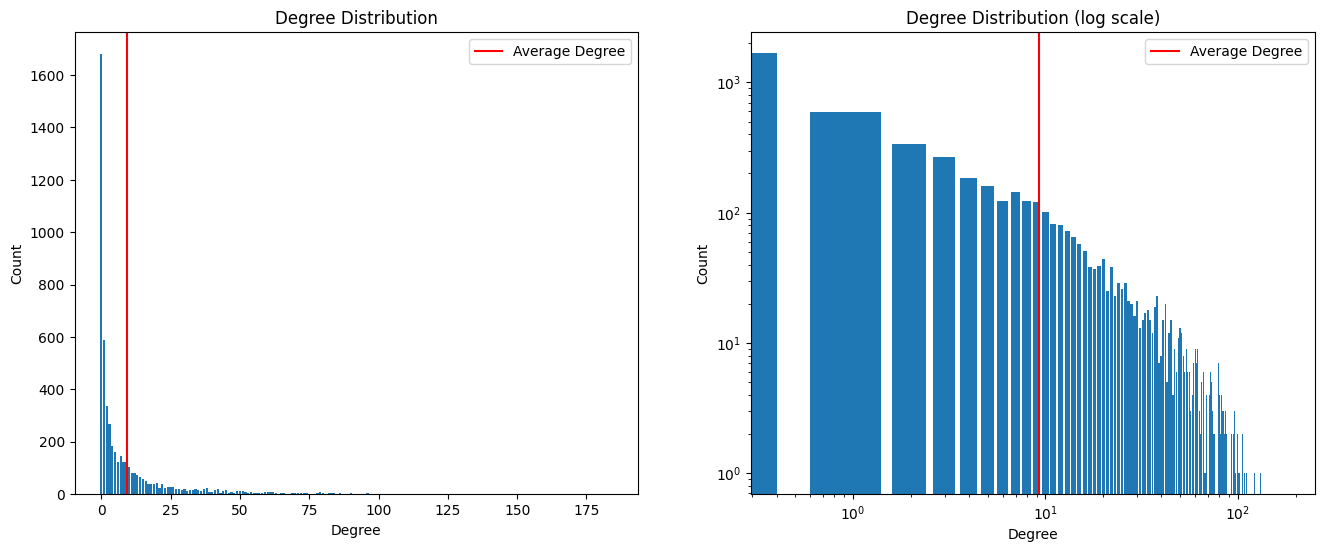

In [32]:
# Calculate degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=False)  # sort in ascending order
degree_count = nx.degree_histogram(G)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# degree distribution
axs[0].bar(range(len(degree_count)), degree_count, align='center')
axs[0].axvline(average_degree, color='r', linestyle='-', label='Average Degree')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('Count')
axs[0].set_title('Degree Distribution')
axs[0].legend()

# loglog degree distribution
axs[1].bar(range(len(degree_count)), degree_count, align='center')
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('Count')
axs[1].set_title('Degree Distribution (log scale)')
axs[1].axvline(average_degree, color='r', linestyle='-', label='Average Degree')
axs[1].legend()

plt.show()

The unweighted degree distribution is plotted in normal scale and log-log-scale. On normal scale, it is clear to see the heavy-tailed distribution, which is further established through the linearity on the log-log-scale. 

### Most collaborative pairs in the network

In [33]:
# Sort the edges by weight in descending order
sorted_edges = sorted(G.edges.data(), key=lambda x: x[2]['weight'], reverse=True)
most_connected_actors = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
most_connected_actors_weighted = sorted(weighted_degrees.items(), key=lambda x: x[1], reverse=True)

print("Top 5 actors with the highest degree:")
for i, actor in enumerate(most_connected_actors[:5], start=1):
    print(f"{i}: Degree: {actor[1]},\t ({G.nodes[actor[0]]['main_genre']})\t {actor[0]}")

print("\nTop 5 actors with the highest weighted degree:")
for i, actor in enumerate(most_connected_actors_weighted[:5], start=1):
    print(f"{i}: Degree: {actor[1]},\t ({G.nodes[actor[0]]['main_genre']})\t {actor[0]}")

print("\nTop 5 most important edges:")
for i, edge in enumerate(sorted_edges[:5], start=1):
    print(f"{i}: Degree: {edge[2]['weight']}, ({G.nodes[edge[0]]['main_genre']} - {G.nodes[edge[1]]['main_genre']}) \t {edge[0]} - {edge[1]}")

Top 5 actors with the highest degree:
1: Degree: 184,	 (Action)	 Samuel L. Jackson
2: Degree: 142,	 (Action)	 Stan Lee
3: Degree: 132,	 (Documentary)	 Benedict Cumberbatch
4: Degree: 131,	 (Comedy)	 Bill Hader
5: Degree: 129,	 (Animation)	 Fred Tatasciore

Top 5 actors with the highest weighted degree:
1: Degree: 619,	 (Animation)	 Grey DeLisle
2: Degree: 561,	 (Animation)	 Fred Tatasciore
3: Degree: 546,	 (Action)	 Samuel L. Jackson
4: Degree: 541,	 (Animation)	 Tara Strong
5: Degree: 492,	 (Animation)	 Hiroshi Kamiya

Top 5 most important edges:
1: Degree: 46, (Animation - Animation) 	 Frank Welker - Grey DeLisle
2: Degree: 42, (Action - Action) 	 Adam Copeland - John Cena
3: Degree: 36, (Animation - Animation) 	 Ikue Otani - Megumi Hayashibara
4: Degree: 35, (Action - Documentary) 	 John Cena - Michael Hickenbottom
5: Degree: 34, (Action - Action) 	 Dwayne Johnson - John Cena


For the unweighted network, Samuel L. Jackson was at the top and is thus the actor with most unique collaborations in the popular actor network. For the weighted network, Grey DeLisle was at the top meaning she has the most total collaborations with popular actors in the network.
The two actors with the highest weighted edge were Frank Welker and Grey DeLisle, who are best known for being the voices of two Scooby Doo characters. Interestingly, three of the five pairs in the top five are three wrestling pairs who are all known from the American WWE.

### Determining the regime of the network

In [ ]:
# Compute the probability that makes the expected number of edges equal to the actual number of edges in the graph.
p = 2*L/(N*(N-1))
print("Prob:",p)

# Compute the natural logarithm of N
ln_N = np.log(N)

print(f"k: {average_degree:.2f} > ln(N): {ln_N:.2f}\np: {p:.5f} > ln(N)/N: {ln_N/N:.5f}")

As the average degree is 9.31 and the logarithm of N is 8.54 (<k> > ln(N)), the network must fall into the connected regime. It is therefore above the critical threshold.

### Plot the network according to birthplace

In [ ]:
# Plot with netwulf
G_plot_nation = G.copy()

for k, v in G_plot_nation.nodes(data=True):
    v['group'] = v['birthplace']; del v['birthplace']

network, config = nw.visualize(G_plot_nation)

In [ ]:
# Find the color of all nodes in the network and find the top 10 most used colors
node_colors = [node['color'] for node in network['nodes']]

# Count the frequency of each color
color_counts = pd.Series(node_colors).value_counts()

# Get the top 10 most used colors
top_10_colors = color_counts.head(10)

# Create color dictionary
color_dict = {}

# Go through the nodes and assign the color to the birthplace
for color in top_10_colors.index:
    for node in network['nodes']:
        if node['color'] == color:
            color_dict[color] = df_actors_filtered[df_actors_filtered['actor']==node['id']]['birthplace'].values[0]
            break

# Print the color dictionary
for color, birthplace in color_dict.items():
    print(f"Color: {color}, Birthplace: {birthplace}")

In [ ]:
# Creating a color legend for the countries
patches = [mpatches.Patch(color=color, label=f"{color_dict[color]}") for color in color_dict]

plt.figure(figsize=(5,2))
plt.legend(handles=patches, loc='center', frameon=False)
plt.axis('off')
plt.show()

In [ ]:
fig,ax = nw.draw_netwulf(network)
plt.legend(handles=patches, loc='upper left', frameon=False)
fig.set_size_inches(12, 8)

In [ ]:
# Save the figure
# fig.savefig('figures/country_graph.png')

# Load the saved png-file "country_graph.png" and plot it in the notebook
Image(filename='figures/country_graph.png')

The visualization of the network shows, as expected, that there are a lot of large american actors in the network, who seem to clustered very central in the network. Furthermore, the actors from the U.K. are primarily clustered in the bottom left side of the giant middle component. But more interestingly, a very clear cluster is formed at the top of the plot, where the all Japanese actors are very closely linked but quite isolated from the giant component in the middle. Another interesting cluster is the Korean cluster to the left of the giant component. These actors are also isolated from the rest of the nodes in the giant component. 

It seems reasonable to have clusters like the Japanese and Korean cluster, as these actors most likely work on movies in their respective native languages and thus with other actors from these countries. 

### Calculate assortativity

In [ ]:
# Calculate the degree assortativity coefficient
degree_assortativity = nx.degree_assortativity_coefficient(G)

# Calculate the attribute assortativity coefficient
country_assortativity = nx.attribute_assortativity_coefficient(G, 'birthplace')

gender_assortativity = nx.attribute_assortativity_coefficient(G, 'gender')

# Calculate the numeric assortativity coefficient
age_assortativity = nx.numeric_assortativity_coefficient(G, 'age')

# Calcualte the assortativity for main_genre
main_genre_assortativity = nx.attribute_assortativity_coefficient(G, 'main_genre')

rating_assortativity = nx.numeric_assortativity_coefficient(G, 'avg_rating')
popularity_assortativity = nx.numeric_assortativity_coefficient(G, 'popularity')

print(f"Categorical:\nGenre assortativity: {main_genre_assortativity}, \nBirth place assortativity: {country_assortativity}, \nGender assortativity: {gender_assortativity}")

print(f"\nNumeric:\nDegree assortativity: {degree_assortativity}, \nAge assortativity: {age_assortativity}, \nRating assortativity: {rating_assortativity}, \nPopularity assortativity: {popularity_assortativity}")

Since there are both categorical and numeric attributes, they will be compared seperately. For the categorical attributes, the birth place assortativity is the highest at 0.47. This suggests that actors born in the same country are more likely to collaborate. The value of 0.47 makes sense, as movies of recent times typically features a diverse cast from different nations, implying that actors will not exclusively work with those from their own country. The genre assortativity is also positive at 0.34, again meaning that actors that work on similar types of movies are more likely to collaborate. Since the popular actors network has a gender assortativity close to 0, the connections and clusters are formed independently from gender. 

When looking at the numeric attributes, the rating is the most assortative attribute with a value of 0.45. This implies that in the popular actor network highly rated actors tend to work with other highly rated actors. The age assortativity is at 0.32, suggesting that the actor network might be segmented into groups based on age. While the degree and popularity assortativity are slightly positive, these attributes might not be the most influential factors in group formation within the network.

### Calculating the closeness and eigenvector centrality

In [34]:
# Calculate the closeness centrality of the network
closeness_centrality = nx.closeness_centrality(G)
# Calculate the eigenvector centrality of the network
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sort the actors according to the closeness centrality
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
# Sort the scientists according to the eigenvector centrality
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

In [35]:
# Find the 10 most central actors
most_central_actors_closeness = sorted_closeness_centrality[:10]
# Find the 10 most central actors
most_central_actors_eigenvector = sorted_eigenvector_centrality[:10]

print(f'{"Actor (Closeness Centrality)":<30} {"Score":<10} | {"Actor (Eigenvector Centrality)":<30} {"Score"}')
print('-'*80)
for actor1, actor2 in zip(most_central_actors_closeness, most_central_actors_eigenvector):
    print(f'{actor1[0]:<30} {actor1[1]:<10.3f} | {actor2[0]:<30} {actor2[1]:.3f}')

Actor (Closeness Centrality)   Score      | Actor (Eigenvector Centrality) Score
--------------------------------------------------------------------------------
Samuel L. Jackson              0.236      | Miyuki Sawashiro               0.151
Stan Lee                       0.232      | Hiroshi Kamiya                 0.149
Fred Tatasciore                0.229      | Takahiro Sakurai               0.149
Benedict Cumberbatch           0.225      | Yuki Kaji                      0.147
Matt Damon                     0.225      | Shin-ichiro Miki               0.147
Tom Hanks                      0.224      | Toshiyuki Morikawa             0.145
Bruce Willis                   0.224      | Jun Fukuyama                   0.143
Bill Hader                     0.222      | Yuichi Nakamura                0.142
Chris Pratt                    0.221      | Mamoru Miyano                  0.142
Liam Neeson                    0.221      | Ayane Sakura                   0.141


The top 10 actors according to the closeness and eigenvector centrality are completely different. Closeness centrality finds the most central actors as all English-speaking and very popular in the Western world. However, the eigenvector centrality shows a list of only Japanese actors, who are primarily grouped in a closely linked, isolated cluster in the network visualization. The reason that the eigenvector centrality prioritizes the Japanese actors is due to their strong connections within their cluster. As the actors are closely linked to each other, they all amplify the influence of each other. Even though these actors are quite isolated, their tight relations mean that they have a high degree of influence in their own cluster. 

### Plotting the closeness and eigenvector centrality

In [ ]:
# Plot the closeness centrality vs node degree to see if there is a correlation
closeness_centrality_values = list(closeness_centrality.values())
eigenvector_centrality_values = list(eigenvector_centrality.values())
degree_values = list(dict(G.degree()).values())

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the closeness centrality vs node degree to see if there is a correlation
axs[0].scatter(degree_values, closeness_centrality_values, alpha=0.5)
axs[0].set_xlabel('Node Degree')
axs[0].set_ylabel('Closeness Centrality')
axs[0].set_title('Closeness Centrality vs Node Degree')

# plot the eigenvector centrality vs node degree to see if there is a correlation
axs[1].scatter(degree_values, eigenvector_centrality_values, alpha=0.5)
axs[1].set_xlabel('Node Degree')
axs[1].set_ylabel('Eigenvector Centrality')
axs[1].set_title('Eigenvector Centrality vs Node Degree')

plt.show()

The plot of the closeness and eigenvector centrality are challenging to interpret. In particular, the eigenvector centrality plot is unusual, as most of the nodes appear with a value close to 0. The top 10 actors according to the eigenvector centrality are only Japanese suggesting that all non-zero values represent Japanese actors. To verify this assumption, a new graph and plot are created without the Japanese actors below. 

In [ ]:
df_actors_no_japan = df_actors_filtered[df_actors_filtered['birthplace'] != 'Japan']

G_no_japan = create_network(df_actors_no_japan)

# Calculate the closeness centrality of the network
closeness_centrality = nx.closeness_centrality(G_no_japan)
# Calculate the eigenvector centrality of the network
eigenvector_centrality = nx.eigenvector_centrality(G_no_japan)

# Plot the closeness centrality vs node degree to see if there is a correlation
closeness_centrality_values = list(closeness_centrality.values())
eigenvector_centrality_values = list(eigenvector_centrality.values())
degree_values = list(dict(G_no_japan.degree()).values())

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the closeness centrality vs node degree to see if there is a correlation
axs[0].scatter(degree_values, closeness_centrality_values, alpha=0.5)
axs[0].set_xlabel('Node Degree')
axs[0].set_ylabel('Closeness Centrality')
axs[0].set_title('Closeness Centrality vs Node Degree (without Japan)')

# plot the eigenvector centrality vs node degree to see if there is a correlation
axs[1].scatter(degree_values, eigenvector_centrality_values, alpha=0.5)
axs[1].set_xlabel('Node Degree')
axs[1].set_ylabel('Eigenvector Centrality')
axs[1].set_title('Eigenvector Centrality vs Node Degree (without Japan)')

plt.show()

When removing the Japanese actors, the correlation between 

### Textual Data Examination and Analysis

Function used for tokenization of movie abstracts, including cleaning, stemming and removing stopwords.

In [ ]:
stemmer = PorterStemmer()

def tokenize_and_clean(text, collocations={}, with_collocations=False): #takes text and dictionary of collocations
    # Exclude symbols and numbers
    text = re.sub(r'\b\d+\b', '', text)
    # Exclude punctuation and convert to lowercase
    text = re.sub(r'\W', ' ', text).lower()

    # Tokenize
    if with_collocations:
        tokenizer = MWETokenizer(list(collocations.keys()))
        tokens = word_tokenize(text)
        tokens = tokenizer.tokenize(tokens)
    else:
        tokens = word_tokenize(text)
    # stem
    tokens = [stemmer.stem(token) for token in tokens if token not in stopwords.words('english')]# TO REMOVE STOPWORDS 
    return tokens

In [ ]:
# First clean text
df_movies_filtered['tokens'] = df_movies_filtered['abstract'].apply(lambda x: tokenize_and_clean(x))

Bigram and Collocation work

In [ ]:
# Initialize an empty list to store all bigrams
all_bigrams = []

# For each list of tokens in the 'tokens' column
for tokens in df_movies_filtered['tokens']:
    # Generate the list of bigrams
    bigrams_list = list(bigrams(tokens))
    # Add the bigrams to the list of all bigrams
    all_bigrams.extend(bigrams_list)

In [ ]:
all_unique_bigrams = list(set(all_bigrams))
tokens_list = list(df_movies_filtered['tokens'].copy().explode())

# Create a Counter for bigrams and tokens
bigrams_counter = collections.Counter(all_bigrams)
tokens_counter = collections.Counter(tokens_list)

# Create a dictionary to store the data
data = {}

# For each unique pair of words
for w1, w2 in tqdm(all_unique_bigrams):
    # number of times w1 and w2 appear together in all_bigrams
    nii = bigrams_counter[(w1, w2)]
    # number of times w1 appears without w2
    noi = tokens_counter[w1] - nii
    # number of times w2 appears without w1
    nio = tokens_counter[w2] - nii
    # number of times w1 and w2 do not appear together
    noo = len(all_bigrams) - nii - noi - nio

    O = [[nii, nio], [noi, noo]]

    R1 = nii + nio
    C1 = nii + noi
    R2 = noi + noo
    C2 = nio + noo
    N = R1 + R2 + C1 + C2

    E = [[R1*C1/N, R1*C2/N],[R2*C1/N, R2*C2/N]] 

    X_sq = sum((O[i][j] - E[i][j]) ** 2 / E[i][j] for i in range(len(O)) for j in range(len(O[i])))
    p_val = stats.chi2.sf(X_sq, df=1)

    data[(w1, w2)] = O, E, p_val

In [ ]:
len(df_movies_filtered['tokens'].explode())

In [ ]:
collocations = {}

for w1, w2 in tqdm(all_unique_bigrams):
    if bigrams_counter[(w1, w2)] > 10 and data[(w1, w2)][2] < 0.001:
        collocations.update({(w1, w2): bigrams_counter[(w1, w2)]})

print(f"\nNumber of collocations: {len(collocations)}")
# Print out the top 20 of them by number of occurrences
sorted(collocations.items(), key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# recomputing the tokens with collocations
df_movies_filtered['tokens'] = df_movies_filtered['abstract'].apply(lambda x: tokenize_and_clean(x, collocations, 
                                                                                                       with_collocations=True))

In [ ]:
# # save the dataframe as a csv file called df_movies_tokens
# df_movies_filtered.to_csv('data/df_movies_tokens.csv', index=False)

df_movies_tokens = pd.read_csv('data/df_movies_tokens.csv', converters={'tokens': ast.literal_eval, 'genres': ast.literal_eval})

### Partitioning of network into communities

In [ ]:
# Compute the best partition using the Louvain method
partition = community_louvain.best_partition(G, resolution=3)

# Compute the modularity of this partition
modularity = community_louvain.modularity(partition, G)

print("Modularity found by Louvain algorithm:", modularity)

In [ ]:
# Calculate the number of communities and their sizes
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(node)

num_communities = len(communities)
community_sizes = sorted([len(nodes) for nodes in communities.values()], reverse=True)

print("Number of communities:", num_communities)
print("Sizes of communities:", community_sizes)
# Check if the modularity is significantly different than 0
if abs(modularity) > 0.01:  # or any other threshold you consider significant
    print("The modularity is significantly different than 0.")
else:
    print("The modularity is not significantly different than 0.")

In [ ]:
# Create a DataFrame from the partition and degree information
df_communities = pd.DataFrame({
    'actor': list(G.nodes),
    'community': [partition[node] for node in G.nodes],
    'degree': [G.degree(node) for node in G.nodes]
})

# Save the dataframe to csv
df_communities.to_csv('data/communities.csv', index=False)

In [ ]:
# Load the df_communities csv-file
df_communities = pd.read_csv('data/communities.csv')

### Community data collecting

In [ ]:
# Merge actors_works_df with communities_df
df = pd.merge(df_actors_filtered, df_communities, on='actor')
df = df.drop(columns=["movies"]).explode('movie_IDs')


# Merge with abstracts_df
df = pd.merge(df, df_movies_tokens, left_on='movie_IDs', right_on='movie_ID')

# # Get abstract tokens for all communities
all_communities_abstracts = df.groupby('community')['tokens'].agg("sum").reset_index()

all_communities_abstracts.columns = ['Community', 'Abstract Tokens']

In [ ]:
# Merge df_actors_filtered with communities df
df_actors_communities = pd.merge(df_actors_filtered, df_communities, on='actor')

# For community in top20_communities, calculate community attributes
# Extract top 20 communities
top20_communities_idx = df_communities['community'].value_counts().nlargest(45).index
top20_community_actors = df_actors_communities[df_actors_communities['community'].isin(top20_communities_idx)]

# Calculate in each community (group_by)
def average_of_list(x):
    return np.mean([val for sublist in x for val in sublist])
def sum_dicts(dicts):
    result = {}
    for d in dicts:
        for k, v in d.items():
            if k in result:
                result[k] += v
            else:
                result[k] = v
    return result
top20_community_attributes = top20_community_actors.groupby('community').agg({
    'actor': 'count',
    'age': 'mean',
    'ratings': [('mean', average_of_list)],
    'popularity': 'mean',
    'degree': [('mean', 'mean')],
    'birthplace': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
})

# Clean columns
top20_community_attributes.columns = ['_'.join(col).strip() for col in top20_community_attributes.columns.values]
top20_community_attributes.reset_index(inplace=True)

# Calculate main genre in each community
df_grouped = df_actors_communities.groupby('community')['genres'].apply(sum_dicts).reset_index()
df_grouped = df_grouped.dropna()
df_grouped = df_grouped.loc[df_grouped.groupby('community')['genres'].idxmax()]
top20_community_attributes = pd.merge(top20_community_attributes, df_grouped, on='community', how='inner')
top20_community_attributes = top20_community_attributes.drop(columns=['genres'])

# Rename columns
top20_community_attributes = top20_community_attributes.rename(columns={'birthplace_<lambda>': 'birthplace'})
top20_community_attributes = top20_community_attributes.rename(columns={'level_1': 'main_genre'})

# Create a success column that sums popularity and rating means
rating_min = top20_community_attributes['ratings_mean'].min()
rating_max = top20_community_attributes['ratings_mean'].max()
popularity_min = top20_community_attributes['popularity_mean'].min()
popularity_max = top20_community_attributes['popularity_mean'].max()

rating_standardized = ((top20_community_attributes['ratings_mean'] - rating_min)/(rating_max - rating_min))
popularity_standardized = ((top20_community_attributes['popularity_mean'] - popularity_min)/(popularity_max - popularity_min))

top20_community_attributes['success'] = rating_standardized * popularity_standardized

# top20_community_attributes.sort_values(by='ratings_mean', ascending=False)

### TF-IDF for wordclouds

In [ ]:
# Get the top 9 communities and filter the abstracts for these communities
# top9_communities = df_communities['community'].value_counts().nlargest(9).index
top9_communities_idx = top20_community_attributes['ratings_mean'].nlargest(9).index

top9_communities = top20_community_attributes.iloc[top9_communities_idx]['community']

# find the top 9 community abstracts
top9_communities_abstracts = all_communities_abstracts[all_communities_abstracts['Community'].isin(top9_communities)]

top_terms = {}
top_tfidf_terms = {}
all_tfidf_terms = {}

# (for less computational cost) get IDF for each term once and store the results
idf_dict = {}
for term in tqdm(set.union(*top9_communities_abstracts['Abstract Tokens'].apply(set))):
    idf_dict[term] = math.log(len(top9_communities_abstracts) / 
                              sum(term in abstract for abstract in top9_communities_abstracts['Abstract Tokens']))


for community in tqdm(top9_communities):
    # Get abstract tokens for the community
    abstract_tokens = top9_communities_abstracts[top9_communities_abstracts['Community'] == community]['Abstract Tokens'].values[0]
    
    # The top 10 TF terms
    term_counts = Counter(abstract_tokens)
    top_terms[community] = term_counts.most_common(10)


    tfidf = {}
    for term, count in term_counts.items():
        # TF for all terms in top 9 communities
        tf = count / len(abstract_tokens)

        # Get IDF from the precalculated dictionary
        idf = idf_dict[term]
        
        # TF-IDF for all terms in top 9 communities
        tfidf[term] = tf * idf

    all_tfidf_terms[community] = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    
    # Get the top 10 TF-IDF words
    top_tfidf_terms[community] = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:10]

In [ ]:
for item in top_tfidf_terms.items():
    print(f"Community {item[0]}:")
    print(', '.join([term[0] for term in item[1]]))


In [ ]:
top9_communities_df = df_communities[df_communities['community'].isin(top9_communities)]

# Group by Community and Actor, and sum the Degree to get the total Degree for each Actor in each Community
grouped_df = top9_communities_df.groupby(['community', 'actor'])['degree'].sum().reset_index()

# Make new dataframe storing the top 5 actors by degree for each community
top_actors = grouped_df.groupby('community').apply(lambda x: x.nlargest(5, 'degree')).reset_index(drop=True)

In [ ]:
# Save all_tfidf_terms as a JSON file in the data folder
with open('data/all_tfidf_terms.json', 'w') as f:
    json.dump(all_tfidf_terms, f)

# Save top9_communities as a CSV file in the data folder
pd.DataFrame(top9_communities, columns=['community']).to_csv('data/top9_communities.csv', index=False)

# Save top_actors as a CSV file in the data folder
top_actors.to_csv('data/top_actors.csv', index=False)

In [ ]:
# load files for wordcloud
top_actors = pd.read_csv('data/top_actors.csv')

top9_communities = pd.read_csv('data/top9_communities.csv')

with open('data/all_tfidf_terms.json', 'r') as file:
    all_tfidf_terms = json.load(file)

### Wordcloud analysis

Now, to closer investigate the communities, the TF-IDF wordcloud plots have been made for the 9 best rated communities. This could help explain what kind of attributes the communities form around - if they form around similar movie types. The wordclouds are based on the TF-IDF, meaning that the sizes of the words on the plots are dependent on the corresponding TF-IDF values. This is done to obtain descriptive and defining words to make it easier to characterize and differentiate the communities. In addition to the wordclouds, the top 5 highest degree actors from each community are printed, since these are the most central actors in the community and could help at understanding the community.

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(24, 24))

for i, community in enumerate(top9_communities["community"]):
    # Get the already calculated top TF-IDF terms for the community
    tfidf_terms = dict(all_tfidf_terms[str(community)])
    
    # Create the word cloud
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate_from_frequencies(tfidf_terms)
    
    # Subplot indices
    row = i // 3
    col = i % 3

    # Plot the word cloud
    axs[row, col].imshow(wordcloud)
    axs[row, col].axis("off")

    # Get the names of the top three actors in the community
    top_three_actors = top_actors[top_actors['community'] == community]['actor'].values
    # Create the title string with newlines
    title_string = "\n".join(top_three_actors)

    # Set title of subplot to the names of the top three actors, each on a new line
    axs[row, col].set_title(f"Top actors in community {community}:\n{title_string}", fontsize=15)

# Remove any extra subplots
for j in range(i+1, 9):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout(pad = 1) 
plt.subplots_adjust(hspace = 0.25)  # Increase the hspace value
plt.show()

In [ ]:
# Save the word cloud to png
# fig.savefig('wordcloud.png')

# load wordcloud
Image(filename='figures/wordcloud.png')

As seen on the plot above, the resulting 9 wordcloud plots are consisting of very different words with different sizes, that are easy to distinct. It is very clear that the communties in these cases are based on types of movies. 
All the 9 communties are easily identifiable, but to highlight a few, the 3rd community in the bottom row is clearly dominated by the Lord of the Rings movies, seen by the words "dwarv" and "hobbit" and the names "bilbo", "gandalf", "smaug", "erebor", etc.
Another interesting observation are the collocations in the first community in the 2nd row, which is a Marvel Avengers (superhero) community. Here, many of the character names are 2-worded, which makes those collocations central in terms of its TF-IDF, since they are central in this community and very rarely seen in other communities. These collocations are for example "spider_man", "iron_man", "captain_america" and "stan_lee".

In both the mentioned communities (and in the other, too), the printed highest degree actors are all very central characters in the movies described by the wordclouds, which makes sense sinse they work with most of the other actors and must star in most of the movies in the community. Note that numerous of these top 5 actors from the same communities have different birthplaces (and ages, and main genre). For example, in the Marvel Superheroes community (community 8), Benedict Cumberbatch is from the UK, while the rest are from the U.S. Since these are the highest degree nodes and therefore the most central in the communities, this signifies that the communities form more based on movie type and maybe less based on birthplace (or age / main genre).

The rest of the communities, starting from the top left, could be categorized as anime (japanese animation), wrestling, korean, Harry Potter, japanese, cartoon and Star Wars.
To further visualize the wordclouds and get a deeper understanding of the communities, a movie poster has been generated based on the top 10 TF-IDF words in 3 chosen communities.

In [ ]:
# Create HTML string for images
html_str = """
<div style="display: flex; justify-content: space-around; align-items: flex-start;">
    <div>
        <img src='figures/marvel.png' style='width: 250px;'>
        <p style="text-align: center;">Community 8</p>
    </div>
    <div>
        <img src='figures/anime_dj.png' style='width: 250px;'>
        <p style="text-align: center;">Community 43</p>
    </div>
    <div>
        <img src='figures/harry_potter.png' style='width: 250px;'>
        <p style="text-align: center;">Community 57</p>
    </div>
    <div>
        <img src='figures/starwars.png' style='width: 250px;'>
        <p style="text-align: center;">Community 19</p>
    </div>
</div>
"""

# Display the images
display(HTML(html_str))

Based on the wordclouds and movie posters, it can be concluded that very distinct communities form inside the actor collaboration network.

### What distinguishes well performing communities?

As the final step in the search to the research question, general attributes for each community are compared. This way, it is investigated if there is something that sets the well-performing communties apart from the less successful communities.

Here, only the communities of a size of 10 actors or more are considered, so the success of a community of eg. 2 actors isn't considered. This filtering results in 45 communities, containing 3348 of the actors (5100 before community size filtering).

For each community, the following attributes are calculated:
* **Community age**: Mean actor age
* **Community genre**: most common genre of all movies made by community actors. (Movie counted once for each actor. This way, a movie starring many actors in the community is weighted higher than a movie only starring one actor.)
* **Community birthplace**: Most common actor birthplace
* **Community rating**: Mean of all ratings obtained by all the actors. (Same weighting strategy as community genre)
* **Community popularity**: Mean actor popularity

Then, each community is plotted with their attribute variables (age/genre/birthplace) vs the goal metric (rating/popularity) in scatter or Mean-SD plots:

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(16, 18))

metrics = ['ratings_mean', 'popularity_mean', 'success']
metrics_map = {'ratings_mean': 'community rating', 'popularity_mean': 'community popularity', 'success': 'community success'}
x_values = ['age_mean', 'main_genre', 'birthplace']
titles = ['Community Age vs ', 'Community Genre vs ', 'Community birthplace vs ']
colors = ['blue', 'green', 'red']  # List of colors for each row

for i, metr in enumerate(metrics):
    for j, x_val in enumerate(x_values):
        ax[i,j].set_title(titles[j] + metrics_map[metr])
        
        # Use scatter plots for 'age_mean' and point plots for the rest
        if x_val == 'age_mean':
            sns.regplot(x=top20_community_attributes[x_val], y=top20_community_attributes[metr], color=colors[i], ax=ax[i,j], ci=95)
            ax[i,j].set_xlabel('Mean Age')
            ax[i,j].set_ylabel(metrics_map[metr])
            
            # Calculate Spearman's correlation
            corr, _ = stats.spearmanr(top20_community_attributes[x_val], top20_community_attributes[metr])
            ax[i,j].text(0.1, 0.9, f'Spearman: {corr:.2f}', transform=ax[i,j].transAxes)
        else:
            order = top20_community_attributes.groupby(x_val)[metr].mean().sort_values().index
            sns.pointplot(x=x_val, y=metr, data=top20_community_attributes, order=order, capsize=.1, linestyle='none', ax=ax[i,j], color=colors[i])
            ax[i,j].set_ylabel(metrics_map[metr])

        # Rotate x-axis labels for each subplot
        for label in ax[i,j].get_xticklabels():
            label.set_rotation(60)
        
        # Adjust age ticks for the first column of subplots
        if j == 0:
            start, end = ax[i,j].get_xlim()
            start, end = int(round(start)), int(round(end))
            ax[i,j].xaxis.set_ticks(np.arange(start, end, 5))
        
        # Add grid to all plots
        ax[i,j].grid(True)

# add vertical space
fig.subplots_adjust(hspace=0.5)

plt.show()

In [ ]:
# Save the figure to a png file
# fig.savefig('figures/community_metrics.png')

# Load community metrics plot
Image(filename='figures/community_metrics.png')

**Rating and popularity**

In the first 2 rows of the plot above, the community attributes are plotted vs the rating and popularity. Here, it is seen that age has no significant impact on success, as the horizontal line is within the confidence interval. Also, the (Spearman's) correlation is very low. Both genre and birthplace seems to have an effect on performance. (Note that no confidence interval is shown when there is only one datapoint for a category).
Although there is a very limited sample size, Japan and Korea seems to perform (significantly) better than many of the other countries in rating. Strangely, in popularity, these two countries seem to underperform while it's the U.S. that performs the best in this metric.

These two metrics do not encapsulate the success of a community, or an actor, for that matter. And in some cases, they seem to be directly opposite, as Japan has the highest mean rating but lowest mean popularity, which means that they are extremely liked but only for a small audience. 

**Success**

Because of these result differences in popularity and rating, a new target measure is made: "success". This is made by standardizing rating and popularity and multiplying them. This way, the prior two metrics are combined, so a community only has a high success-score if it has both a high rating and a high popularity. The popularity score is plotted in the 3rd row in the plot above.

Again, age has no significant impact on success. And because each community's success is now weighted by multiple factors, countries like Japan and U.S. are performing less confidently in rating and popularity, respectively. Now, no single country or genre seems to be performing far better than the others, but there are still some countries (Japan, UK, Korea, U.S. and Australia) that seem to perform better than the rest.


**To summarize the result**, when looking at rating or popularity in isolation, some countries and genres seem to perform significantly better than many of the others. So, if the goal is to become highly rated, the plan would be to move to Japan and make animated movies. And if you want to become popular, you should move to an english speaking country and stay away from TV movies and animation.
However, if you want to be "successful" (i.e. be both popular and highly rated), there is no single plan that 
leads to a significantly more successful acting career. There are only a group of countries that would benefit you more, and certain genres that are more promising, on average.

## 4. Discussion

* ### What went well?

**Community success**

The reason for investigating the attributes for successful and unsuccessful communties rather than for the actors is to give the most useful instructions in how to succeed in an acting career. As a young aspiring actor, you can't actively change your age or birthplace, but you can change who you collaborate with, and ultimately which community you most likely end up in. The final result, although not statistically significant, showed a strategic path that increases the chance of a successful acting career.

**Communty forming**

It was also found that the communities formed based a lot on type of movie. Some were superhero communities, while others were for cartoons, wrestling, or japanese animation. The assortativity for attributes such as genre, rating and birthplace was found to be significantly positive, which means that nodes also tend to cluster based on those attributes. However the communities seemed to form mostly based on movie type.


* ### What is still missing? What could be improved? Why?

**Generalizing in communities**

A fair question would be whether the generalization of the communities was too harsh. For example, in this project, a community would be categorised as Japanese if there were 34% japanese, 33% US, and 33% UK. An example of this was also seen with Benedict Cumberbatch in the Marvel community. In this case, generalizing a community birthplace is not the most accurate method, and could skew the resulting conclusions. However, the assortativities were calculated for the different attributes, and across many of them, the assortativity was significantly positive which means that generalizing across these attributes is not super unreasonable. 
Alternatively, as a solution, the birtplace distribution could be expressed for each community, and the same thing could be done for genre. This could futhermore open up for questions such as "Does diversity among actor nationality increase the success of a community?".

**Data collection and bias**

The data collected about the most popular actors from TMDB reveals notable biases which should be considered when interpreting the results of this project. It was observed that there was a significant imbalance in the actor nationalities, as over 50% of the actors in our network originated from the US, while the second most represented nationality is the United Kingdom which only accounted for 13% of the total actors. This is showing a bias towards American actors for the most popular actors within TMDB. This bias in the nationality representation among actors could be due to various reasons, such as the geographical focus of TMDB’s user base, the language dominance of English in the film industry, and the popularity of Hollywood productions on the platform. But it's important to address that this bias may skew analyses and conclusions drawn from our data, especially concerning those related to nationality or culture. 

Likewise, the distribution of main genres among actors is also very uneven. Comedy genre was representing 35% of the actors’ main genre in movies they acted in while other genres had a much lower representation percentage. This can again affects the drawn conclusions and could also be tackled by focusing on diversifying data sources.

**Bigger dataset for significant results**

One of the shortcomings of this project is the final amount of communities and attributes. This leads to very scarce plots and no significant impacts in success. 
To solve this shortcoming, simply scraping more data with the API or using more sites and APIs could be done. This would increase the data size and could reduce the bias but would also increase the running time. It would also lead to more datapoints in the final results, which could lead to more meaningful conclusions.

**Variable dependency**

For future work, it could be interesting to look further into the attributes and how they contribute to success in terms of rating and popularity. However, Korean love stories might be considered generally good where American love stories might be less successful. The different combinations of attributes and their dependence on each other is something that this project has not explored but could be an idea for future work. This could be done by plotting multiple attributes at a time e.g. through heatmaps, where the color illustrates success, and the attributes are on the axes.

**Natural Language Processing**

The natural language processing was done on somewhat short abstracts of each movie, averaging less than 50 words. Some of them were around 10 words, and some were even in other languages than english. To tackle these challenges, other sites could be scraped for longer and english-languaged abstracts. Alternatively, the foreign languaged abstracts could be translated with a package before doing the stop-word removal and tokenization.

**Further development and analysis**

Here, a (very) short description is made of possibilities for further development and analysis.

* **Network through time.** The collaborations could either be time stamped for analysis across time or an entirely new network could be created - both scenarios expanding to also incorporate movies before 2010.
* **Viewer sentiment analysis.** Viewer reviews could be scraped from the internet to make a sentiment analysis. Here, the user sentiment could be done across different genres, ages or countries. 
* **Expanding the network.** Looking at more actors, so it's not only the collaboration between popular actors, but all actors in general. This would change the fact that now, if someone only collaborates with unpopular actors, they will have 0 links. 